File Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
import os
import pickle
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_recall_fscore_support, roc_curve, auc
)
import warnings
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Classes Defined for Dataset Generation and Augmentation

In [2]:
class DatasetGenerator:
    """Generate larger dataset with better class separation."""

    def __init__(self, radar_gen, processor, num_samples=1500):
        """Increase from 300 to 1500 samples."""
        self.radar_gen = radar_gen
        self.processor = processor
        self.num_samples = num_samples

    def generate_metal_sample(self):
        """Metal: High RCS, strong reflections."""
        target_range = np.random.uniform(1.0, 5.5)
        target_velocity = np.random.uniform(-3.0, 3.0)
        rcs = np.random.uniform(18.0, 30.0)  # Increased minimum RCS

        targets = [{
            'range': target_range,
            'velocity': target_velocity,
            'rcs': rcs
        }]

        # Less clutter for metal
        if np.random.rand() > 0.85:
            targets.append({
                'range': np.random.uniform(1.0, 5.5),
                'velocity': np.random.uniform(-0.3, 0.3),
                'rcs': np.random.uniform(0.1, 0.5)
            })

        signal = self.radar_gen.generate_2d_signal(
            targets,
            noise_power=np.random.uniform(0.001, 0.01)
        )

        return signal, {'label': 'metal', 'rcs': rcs}

    def generate_non_metal_sample(self):
        """Non-metal: Low RCS, diffuse reflections."""
        target_range = np.random.uniform(1.0, 5.5)
        target_velocity = np.random.uniform(-0.8, 0.8)  # More restricted
        rcs = np.random.uniform(0.1, 1.5)  # Reduced maximum RCS

        targets = [{
            'range': target_range,
            'velocity': target_velocity,
            'rcs': rcs
        }]

        # More clutter for non-metal (diffuse reflection)
        if np.random.rand() > 0.4:
            num_reflections = np.random.randint(2, 5)
            for _ in range(num_reflections):
                targets.append({
                    'range': np.random.uniform(1.0, 5.5),
                    'velocity': np.random.uniform(-0.5, 0.5),
                    'rcs': np.random.uniform(0.1, 1.0)
                })

        signal = self.radar_gen.generate_2d_signal(
            targets,
            noise_power=np.random.uniform(0.03, 0.06)  # More noise
        )

        return signal, {'label': 'non_metal', 'rcs': rcs}

In [3]:
class RadarDataAugmentation:
    """Augment radar range-Doppler maps."""

    @staticmethod
    def add_noise(rd_map, noise_level=0.05):
        """Add Gaussian noise."""
        noise = np.random.normal(0, noise_level, rd_map.shape)
        return rd_map + noise

    @staticmethod
    def shift_doppler(rd_map, max_shift=5):
        """Shift in Doppler dimension."""
        shift = np.random.randint(-max_shift, max_shift)
        return np.roll(rd_map, shift, axis=1)

    @staticmethod
    def shift_range(rd_map, max_shift=3):
        """Shift in range dimension."""
        shift = np.random.randint(-max_shift, max_shift)
        return np.roll(rd_map, shift, axis=0)

    @staticmethod
    def scale_amplitude(rd_map, scale_range=(0.9, 1.1)):
        """Random amplitude scaling."""
        scale = np.random.uniform(*scale_range)
        return rd_map * scale

    @staticmethod
    def augment_batch(X_batch, augment_prob=0.7):
        """Apply random augmentations to a batch."""
        X_aug = X_batch.copy()

        for i in range(len(X_aug)):
            if np.random.rand() < augment_prob:
                # Apply 1-3 random augmentations
                aug_funcs = [
                    RadarDataAugmentation.add_noise,
                    RadarDataAugmentation.shift_doppler,
                    RadarDataAugmentation.shift_range,
                    RadarDataAugmentation.scale_amplitude
                ]

                num_augs = np.random.randint(1, 4)
                selected_augs = np.random.choice(len(aug_funcs), num_augs, replace=False)

                for aug_idx in selected_augs:
                    X_aug[i, :, :, 0] = aug_funcs[aug_idx](X_aug[i, :, :, 0])

        return X_aug

Analyse Quality of Generated Dataset

In [4]:
def diagnose_dataset_quality(X, y, metadata):
    """Analyze if classes are actually separable."""

    # RCS distribution analysis
    metal_rcs = [m['rcs'] for m, label in zip(metadata, y) if label == 1]
    non_metal_rcs = [m['rcs'] for m, label in zip(metadata, y) if label == 0]

    print(f"\nRCS Statistics:")
    print(f"Metal RCS - Mean: {np.mean(metal_rcs):.2f}, Std: {np.std(metal_rcs):.2f}")
    print(f"          - Range: [{np.min(metal_rcs):.2f}, {np.max(metal_rcs):.2f}]")
    print(f"Non-metal RCS - Mean: {np.mean(non_metal_rcs):.2f}, Std: {np.std(non_metal_rcs):.2f}")
    print(f"              - Range: [{np.min(non_metal_rcs):.2f}, {np.max(non_metal_rcs):.2f}]")

    # Feature separability
    metal_samples = X[y == 1]
    non_metal_samples = X[y == 0]

    metal_mean_intensity = np.mean(metal_samples)
    non_metal_mean_intensity = np.mean(non_metal_samples)

    print(f"\nMean Intensity:")
    print(f"Metal: {metal_mean_intensity:.4f}")
    print(f"Non-metal: {non_metal_mean_intensity:.4f}")
    print(f"Difference: {abs(metal_mean_intensity - non_metal_mean_intensity):.4f}")

    if abs(metal_mean_intensity - non_metal_mean_intensity) < 0.1:
        print("WARNING: Classes may not be sufficiently separated!")


### Class for Model Defination and Training

In [5]:
class RadarCNN:
    """Lighter CNN architecture to prevent overfitting."""

    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self._build_model()

    def _build_model(self):
        """Build simplified CNN - fewer layers, less parameters."""
        model = models.Sequential([
            # Input
            layers.Input(shape=(*self.input_shape, 1)),

            # Conv Block 1 - Reduced filters
            layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.2),

            # Conv Block 2
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.4),

            # Conv Block 3 - Removed one conv layer per block
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.5),

            # Simplified Dense layers
            layers.GlobalAveragePooling2D(),
            layers.Dense(64, activation='relu'),  # Reduced from 256
            layers.BatchNormalization(),
            layers.Dropout(0.6),

            # Output
            layers.Dense(2, activation='softmax')
        ])

        return model

    def compile_model(self, learning_rate=0.0005):
        """Use lower learning rate."""
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')]
        )

    def summary(self):
        return self.model.summary()

Model Training with Data Augmentation

In [12]:
def train_model(X_train, y_train, X_val, y_val, input_shape):
    """Train with improved strategy."""

    # Initialize model
    model = RadarCNN(input_shape)
    model.compile_model(learning_rate=0.0003)

    print("\nModel Architecture:")
    model.summary()
    print(f"\nTotal parameters: {model.model.count_params():,}")

    # Enhanced callbacks
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,  # Increased patience
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=7,
        min_lr=1e-7,
        verbose=1
    )

    # Custom data generator with augmentation
    augmenter = RadarDataAugmentation()

    def data_generator(X, y, batch_size=32, augment=True):
        """Generator with on-the-fly augmentation."""
        num_samples = len(X)
        indices = np.arange(num_samples)

        while True:
            np.random.shuffle(indices)

            for start_idx in range(0, num_samples - batch_size + 1, batch_size):
                batch_indices = indices[start_idx:start_idx + batch_size]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]

                if augment:
                    X_batch = augmenter.augment_batch(X_batch)

                yield X_batch, y_batch

    # Calculate steps
    batch_size = 32
    steps_per_epoch = len(X_train) // batch_size
    validation_steps = len(X_val) // batch_size

    # Train with generator
    print("\nTraining with data augmentation...")
    history = model.model.fit(
        data_generator(X_train, y_train, batch_size, augment=True),
        steps_per_epoch=steps_per_epoch,
        validation_data=data_generator(X_val, y_val, batch_size, augment=False),
        validation_steps=validation_steps,
        epochs=20,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    return model, history

### Pipeline Implementation

In [7]:
# Import from Part 1 and Initialze Components
from radar_simulation import (
    RadarSignalGenerator, RadarProcessor)
# Initialize components
radar_gen = RadarSignalGenerator()
processor = RadarProcessor()

Radar Configuration:
  Range Resolution: 0.037 m
  Max Range: 0.00 m
  Velocity Resolution: 0.380 m/s


Generate Dataset

In [8]:
#Generate Dataset
dataset_gen = DatasetGenerator(
    radar_gen=RadarSignalGenerator(),
    processor=RadarProcessor(),
    num_samples=1500  # Increased from 300
)

# Generate dataset generator
print(f"Generating {dataset_gen.num_samples} synthetic samples...")
samples_per_class = dataset_gen.num_samples // 2
X_list = []
y_list = []
metadata_list = []

# Generate metal samples
print(f"  Generating {samples_per_class} metal samples...")
for i in range(samples_per_class):
    signal, metadata = dataset_gen.generate_metal_sample()
    range_fft = processor.range_fft(signal, window='hann')
    rd_map = processor.doppler_fft(range_fft, window='hann')
    rd_mag = processor.compute_magnitude(rd_map, db=True)

    X_list.append(rd_mag)
    y_list.append(1)
    metadata_list.append(metadata)

    if (i + 1) % 100 == 0:
        print(f"    Progress: {i + 1}/{samples_per_class}")

# Generate non-metal samples
print(f"  Generating {samples_per_class} non-metal samples...")
for i in range(samples_per_class):
    signal, metadata = dataset_gen.generate_non_metal_sample()
    range_fft = processor.range_fft(signal, window='hann')
    rd_map = processor.doppler_fft(range_fft, window='hann')
    rd_mag = processor.compute_magnitude(rd_map, db=True)

    X_list.append(rd_mag)
    y_list.append(0)
    metadata_list.append(metadata)

    if (i + 1) % 100 == 0:
        print(f"    Progress: {i + 1}/{samples_per_class}")

X = np.array(X_list)
y = np.array(y_list)

# Shuffle
shuffle_idx = np.random.permutation(len(X))
X = X[shuffle_idx]
y = y[shuffle_idx]
metadata_list = [metadata_list[i] for i in shuffle_idx]

print(f"\nDataset generated successfully!")
print(f"  Total samples: {len(X)}")
print(f"  Shape: {X.shape}")

# Save dataset
np.save('classification_model_data/X_features.npy', X)
np.save('classification_model_data/y_labels.npy', y)
with open('classification_model_data/metadata.pkl', 'wb') as f:
    pickle.dump(metadata_list, f)

Radar Configuration:
  Range Resolution: 0.037 m
  Max Range: 0.00 m
  Velocity Resolution: 0.380 m/s
Generating 1500 synthetic samples...
  Generating 750 metal samples...
    Progress: 100/750
    Progress: 200/750
    Progress: 300/750
    Progress: 400/750
    Progress: 500/750
    Progress: 600/750
    Progress: 700/750
  Generating 750 non-metal samples...
    Progress: 100/750
    Progress: 200/750
    Progress: 300/750
    Progress: 400/750
    Progress: 500/750
    Progress: 600/750
    Progress: 700/750

Dataset generated successfully!
  Total samples: 1500
  Shape: (1500, 128, 256)


Data Quality Of Generated Dataset

In [9]:
diagnose_dataset_quality(X, y, metadata_list)


RCS Statistics:
Metal RCS - Mean: 24.01, Std: 3.37
          - Range: [18.02, 29.99]
Non-metal RCS - Mean: 0.82, Std: 0.40
              - Range: [0.10, 1.50]

Mean Intensity:
Metal: 11.0146
Non-metal: 20.5743
Difference: 9.5597


Data Preprocessing

In [10]:
# Normalize
X_normalized = (X - np.mean(X)) / (np.std(X) + 1e-8)
X_normalized = X_normalized[..., np.newaxis]
y_categorical = to_categorical(y, num_classes=2)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_categorical,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.15,
    random_state=42,
    stratify=np.argmax(y_train, axis=1)
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (1020, 128, 256, 1)
Validation set: (180, 128, 256, 1)
Test set: (300, 128, 256, 1)


Train Model

In [13]:
model, history = train_model(
    X_train, y_train, X_val, y_val,
    input_shape=X_train.shape[1:3]
)


Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 128, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 128, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 128, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 128, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,290 (110.51 KB)

 Trainable params: 27,938 (109.13 KB)

 Non-trainable params: 352 (1.38 KB)


Total parameters: 28,290

Training with data augmentation...
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9627 - loss: 0.1318 - precision: 0.9627 - recall: 0.9627 - val_accuracy: 1.0000 - val_loss: 0.6473 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 3.0000e-04
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9990 - loss: 0.0265 - precision: 0.9990 - recall: 0.9990 - val_accuracy: 0.4750 - val_loss: 0.5736 - val_precision: 0.4750 - val_recall: 0.4750 - learning_rate: 3.0000e-04
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9940 - loss: 0.0237 - precision: 0.9940 - recall: 0.9940 - val_accuracy: 0.4875 - val_loss: 0.5102 - val_precision: 0.4875 - val_recall: 0.4875 - learning_rate: 3.0000e-04
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9990 - loss: 0.0155 - precision: 0.9990 - recall: 0.9990 - val_accuracy: 0.7312 - val_loss: 0.4355 - val_precision: 0.7312 - val_recall: 0.7312 - learning_rat

Model Evaluation

In [14]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_recall_fscore_support,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred_proba = model.model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_labels, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test_labels, y_pred, average='binary'
)

print(f"\nTest Set Performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Test Set Performance:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000


In [15]:
# Classification report
print("\nDetailed Classification Report:")
report = classification_report(
    y_test_labels, y_pred,
    target_names=['Non-Metal', 'Metal'],
    digits=4
)
print(report)


Detailed Classification Report:
              precision    recall  f1-score   support

   Non-Metal     1.0000    1.0000    1.0000       150
       Metal     1.0000    1.0000    1.0000       150

    accuracy                         1.0000       300
   macro avg     1.0000    1.0000    1.0000       300
weighted avg     1.0000    1.0000    1.0000       300



In [16]:
# ROC AUC
fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)
print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 1.0000


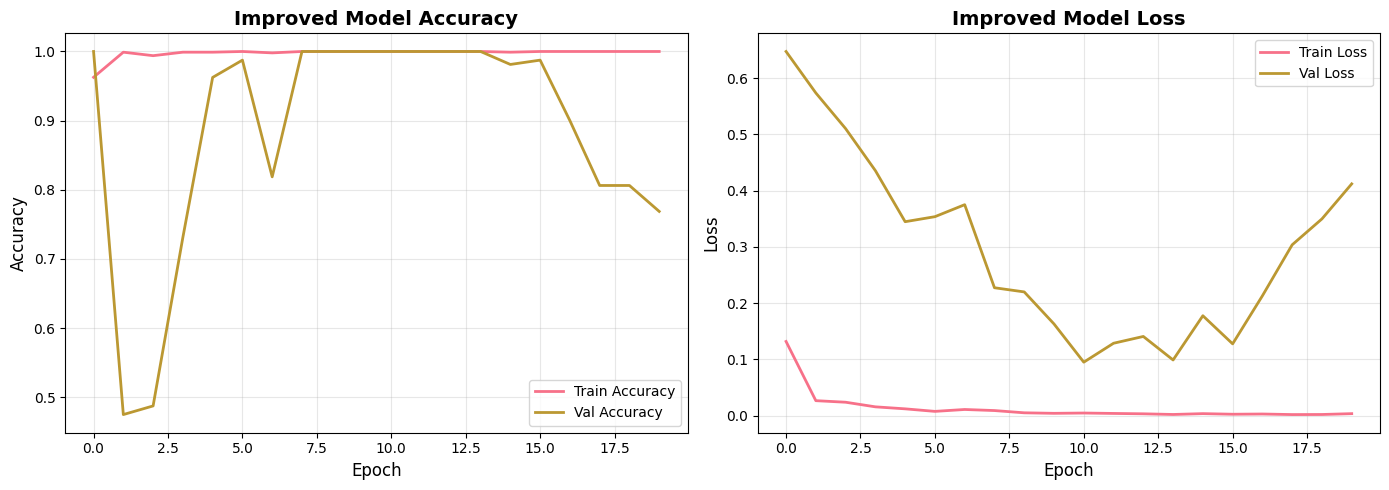

In [17]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Improved Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Improved Model Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('classification_model_outputs/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

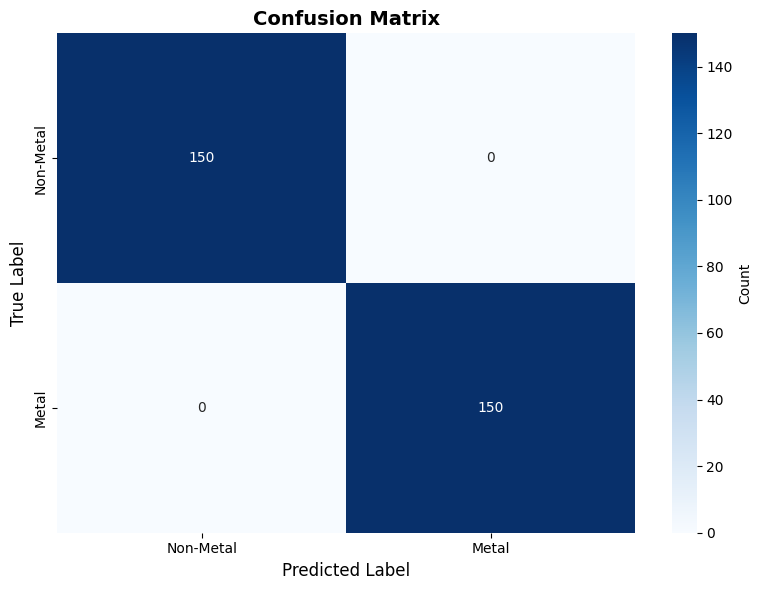

In [18]:
# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Metal', 'Metal'],
            yticklabels=['Non-Metal', 'Metal'],
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('classification_model_outputs/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

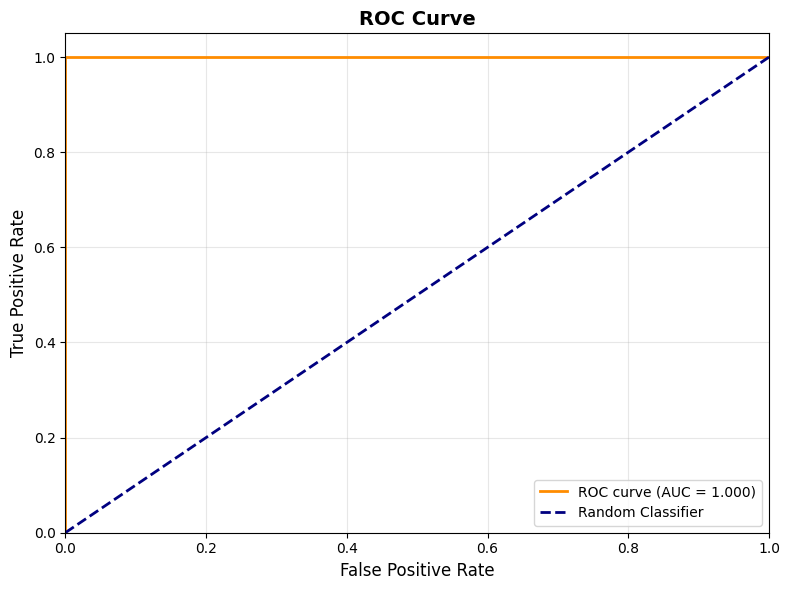

In [19]:
# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2,
        label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
        label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('classification_model_outputs/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

Save Model

In [20]:
model.model.save('classification_model_outputs/metal_classifier_improved.keras')
model.model.save('classification_model_outputs/metal_classifier_improved.h5')
model_info = {
    'input_shape': X_train.shape[1:3],
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'roc_auc': float(roc_auc),
    'num_parameters': model.model.count_params(),
    'num_samples': len(X)
}

with open('classification_model_outputs/model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)